In [2]:
import os
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import numpy as np
import random

In [3]:
key_df = pd.read_csv('/Users/troys/OneDrive/Documents/Python/BeeEye/api_keys.csv')

In [112]:
key_df.loc[key_df['API'] == 'bls', 'KEY'].item()
BLS_API_KEY = key_df.loc[key_df['API'] == 'bls']['KEY'].iloc[0]
BLS_ENDPOINT = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

def fetch_bls_series(series, **kwargs):
    """
    Pass in a list of BLS timeseries to fetch data and return the series
    in JSON format. Arguments can also be provided as kwargs:
        - startyear (4 digit year)
        - endyear (4 digit year)
        - catalog (True or False)
        - calculations (True or False)
        - annualaverage (True or False)
        - registrationKey (api key from BLS website)
    If the registrationKey is not passed in, this function will use the
    BLS_API_KEY fetched from the environment.
    """
    if len(series) < 1 or len(series) > 25:
        raise ValueError("Must pass in between 1 and 25 series ids")
    # Create headers and payload post data
    headers = {'Content-Type': 'application/json'}
    payload = {
        'seriesid': series,
        'registrationKey': BLS_API_KEY,
    }
    # Update the payload with the keyword arguments and convert to JSON
    payload.update(kwargs)
    payload = json.dumps(payload)
    # Fetch the response from the BLS API
    response = requests.post(BLS_ENDPOINT, data=payload, headers=headers)
    response.raise_for_status()
    # Parse the JSON result
    #result = response.json()
    result = json.loads(response.text)
    if result['status'] != 'REQUEST_SUCCEEDED':
        raise Exception(result['message'][0])
    return result

In [113]:
series = ['LNS14000000', 'LNU05026645', 'LNS12032194', 'LNS14027689']
#series = ['LNS14000000', 'LNS14027689']
#series = ['CUUR0000SSEFF01']
json_data = fetch_bls_series(series, startyear=2015, endyear=2022)
#json_data = print(json.dumps(data, indent=2))
#print(json.loads(data.text))

In [114]:
try:
    # Create a list to store individual DataFrames
    dfs = []

    for series in json_data['Results']['series']:
        df_initial = pd.DataFrame(series)
        series_col = df_initial['seriesID'][0]

        for i in range(0, len(df_initial) - 1):
            df_row = pd.DataFrame(df_initial['data'][i])
            df_row['seriesID'] = series_col

            if 'code' not in str(df_row['footnotes']): 
                df_row['footnotes'] = ''
            else:
                df_row['footnotes'] = str(df_row['footnotes']).split("'code': '", 1)[1][:1]

            # Append df_row to the list
            dfs.append(df_row)

    # Concatenate the list of DataFrames into a single DataFrame
    df = pd.concat(dfs, ignore_index=True)

    # Save the final DataFrame to a CSV file
    df.to_csv('blsdata.csv', index=False)

except Exception as e:
    json_data['status'] == 'REQUEST_NOT_PROCESSED'
    print('BLS API has given the following Response:', json_data['status'])
    print('Reason:', json_data['message'])
    print('Error:', str(e))

In [115]:
df

,year,period,periodName,value,footnotes,seriesID
0,2022,M12,December,3.5,,LNS14000000
1,2022,M11,November,3.6,,LNS14000000
2,2022,M10,October,3.7,,LNS14000000
3,2022,M09,September,3.5,,LNS14000000
4,2022,M08,August,3.7,,LNS14000000
...,...,...,...,...,...,...
375,2015,M06,June,4.2,,LNS14027689
376,2015,M05,May,4.4,,LNS14027689
377,2015,M04,April,4.7,,LNS14027689
378,2015,M03,March,4.8,,LNS14027689


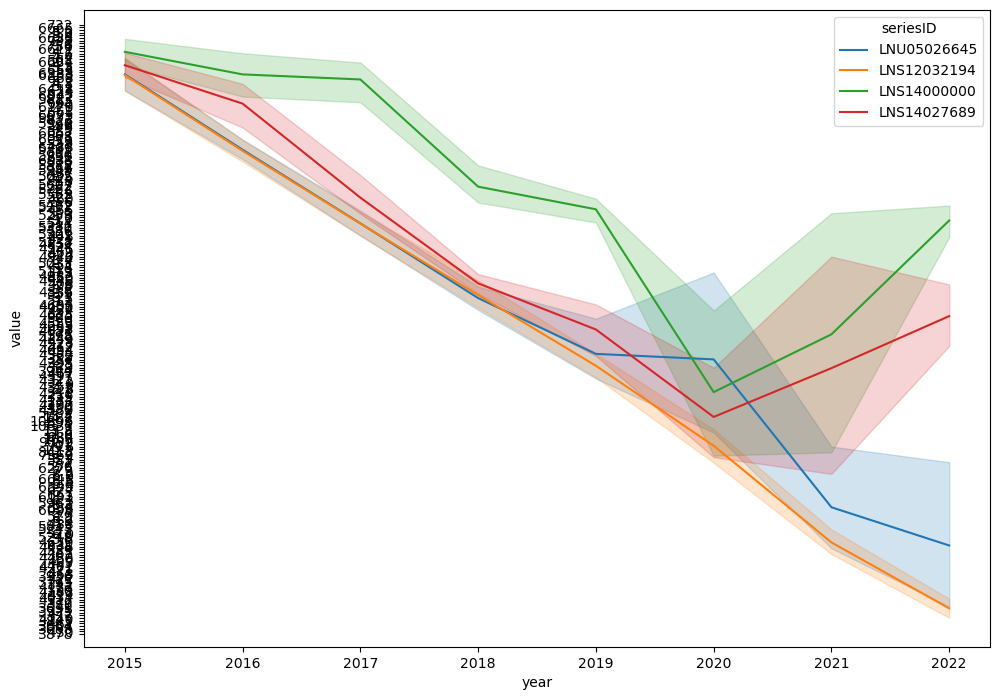

In [99]:
df['periodNum'] = df['period'].str[-2:]
df['yearMonth'] = df['year'] + df['periodNum']

a4_dims = (11.7, 8.27)
fig, ax =  pyplot.subplots(figsize=a4_dims)
ax = sns.lineplot(data=df.sort_values('yearMonth'), x="year", y="value", hue="seriesID", sort=False)
plt.show()

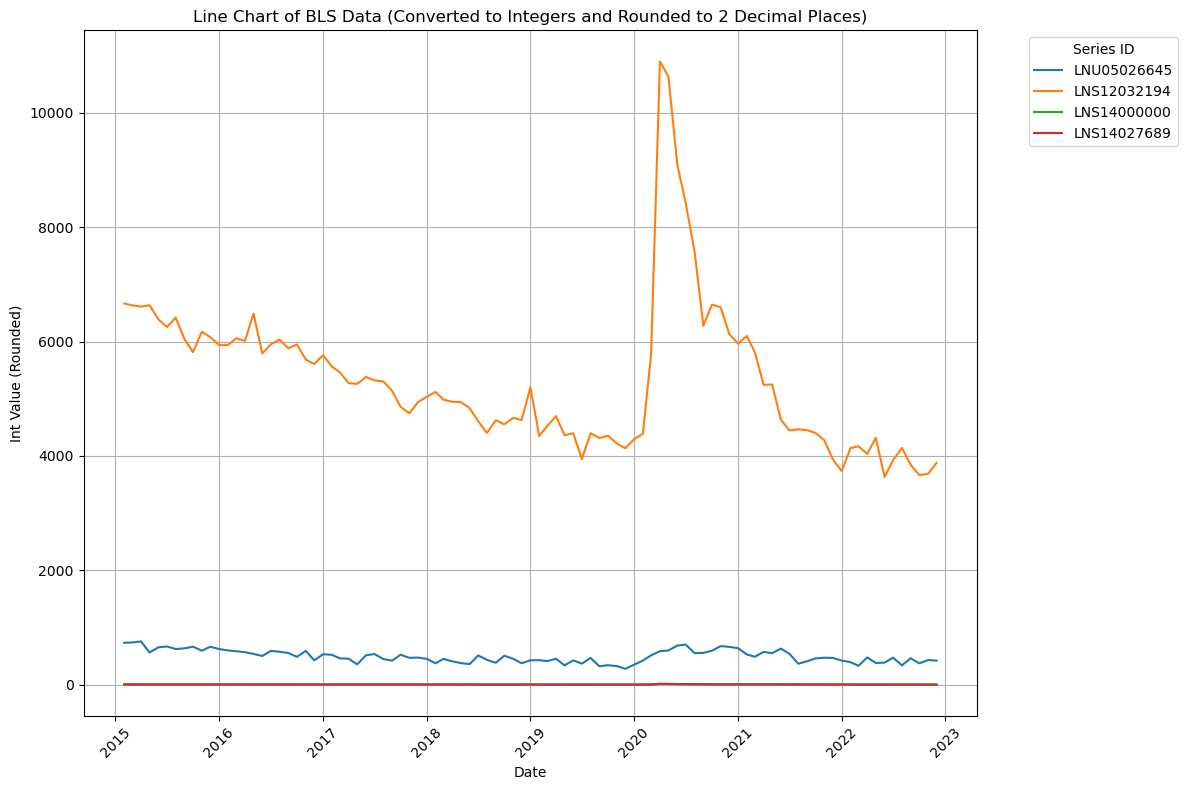

In [116]:
# Specify the correct format for the 'date' column
df['date'] = df['year'].astype(str) + ' ' + df['period']

# Convert 'date' column to datetime type with the correct format
df['date'] = pd.to_datetime(df['date'], format='%Y M%m')

# Convert 'value' column to numeric (handling non-numeric values)
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# Replace NaN values with a default value (e.g., 0) or handle them based on your use case
df['value'] = df['value'].fillna(0)

# Convert 'value' column to integers and then round to a specified number of decimal places (e.g., 2)
decimal_places = 2
df['value'] = df['value'].astype(int).round(decimal_places)

# Sort DataFrame by the 'date' column
df = df.sort_values('date')

# Plotting
plt.figure(figsize=(12, 8))

# Iterate through unique 'seriesID' values
for series_id in df['seriesID'].unique():
    series_data = df[df['seriesID'] == series_id]
    plt.plot(series_data['date'], series_data['value'], label=series_id)

# Customize the plot
plt.title(f'Line Chart of BLS Data (Converted to Integers and Rounded to {decimal_places} Decimal Places)')
plt.xlabel('Date')
plt.ylabel('Int Value (Rounded)')
plt.legend(title='Series ID', bbox_to_anchor=(1.05, 1), loc='upper left')  # Improved legend placement
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()  # Adjust layout for better visualization
plt.show() 

In [117]:
# Specify the correct format for the 'date' column
df['date'] = df['year'].astype(str) + ' ' + df['period']

# Convert 'date' column to datetime type with the correct format
df['date'] = pd.to_datetime(df['date'], format='%Y M%m')

# Convert 'value' column to numeric (handling non-numeric values)
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# Replace NaN values with a default value (e.g., 0) or handle them based on your use case
df['value'] = df['value'].fillna(0)

# Convert 'value' column to integers and then round to a specified number of decimal places (e.g., 2)
decimal_places = 2
df['value'] = df['value'].astype(int).round(decimal_places)

# Sort DataFrame by the 'date' column
df = df.sort_values('date')

In [118]:
df

,year,period,periodName,value,footnotes,seriesID,date
189,2015,M02,February,732,,LNU05026645,2015-02-01
284,2015,M02,February,6665,,LNS12032194,2015-02-01
94,2015,M02,February,5,,LNS14000000,2015-02-01
379,2015,M02,February,5,,LNS14027689,2015-02-01
93,2015,M03,March,5,,LNS14000000,2015-03-01
...,...,...,...,...,...,...,...
286,2022,M11,November,3,,LNS14027689,2022-11-01
285,2022,M12,December,2,,LNS14027689,2022-12-01
190,2022,M12,December,3878,,LNS12032194,2022-12-01
95,2022,M12,December,421,,LNU05026645,2022-12-01


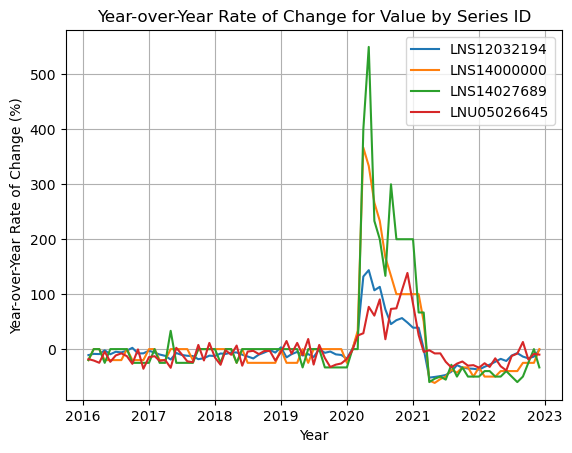

In [119]:
# Calculate year-over-year rate of change for 'value'
df['YOY'] = df.groupby('seriesID')['value'].pct_change(12) * 100

# Plot the line chart for each 'Series ID'
for series_id, group in df.groupby('seriesID'):
    plt.plot(group['date'], group['YOY'], label=series_id)

# Customize the plot
plt.title('Year-over-Year Rate of Change for Value by Series ID')
plt.xlabel('Year')
plt.ylabel('Year-over-Year Rate of Change (%)')
plt.legend()
plt.grid(True)
plt.show()